# <b><h1>Heart Disease Project v. 2.0</h1></b>

This is it! After nearly 6 months-long hiatus the heart disease project is back on. Not only because it's a fairly straight forward dataset, but also because it's a good starting point for practicing with creating a Neural Network from the ground up. In this notebook I will follow the usual drill, that is:

 - Defining the problem
 - EDA and preprocessing the data
 - Creating the initial network and tuning it
 - Evaluating the model
 - Experimenting untill satisfied

 Just to catch up - I am working with a dataset <a href="https://www.kaggle.com/datasets/cherngs/heart-disease-cleveland-uci/code?select=heart_cleveland_upload.csv">from Kaggle</a> and it's an updated version of the original Cleveland heart disease dataset. It's been <u>defined</u> on the dataset page already but to reiterate - it's a binary classification problem, where the patient can be either healthy or suffer from the heart disease. The features are the parameters of each patient, and they are:

 1. age: age in years
 2. sex: sex (1 = male; 0 = female)
 3. cp: chest pain type
    <br />a) Value 0: typical angina
    <br />b) Value 1: atypical angina
    <br />c) Value 2: non-anginal pain
    <br />d) Value 3: asymptomatic
 4. trestbps: resting blood pressure (in mm Hg on admission to the hospital)
 5. chol: serum cholestoral in mg/dl
 6. fbs: (fasting blood sugar > 120 mg/dl) (1 = true; 0 = false)
 7. restecg: resting electrocardiographic results
    <br />-- Value 0: normal
    <br />-- Value 1: having ST-T wave abnormality (T wave inversions and/or ST elevation or depression of > 0.05 mV)
    <br />-- Value 2: showing probable or definite left ventricular hypertrophy by Estes' criteria
 8. thalach: maximum heart rate achieved
 9. exang: exercise induced angina (1 = yes; 0 = no)
 10. oldpeak = ST depression induced by exercise relative to rest
 11. slope: the slope of the peak exercise ST segment
   <br />-- Value 0: upsloping
   <br />-- Value 1: flat
   <br />-- Value 2: downsloping
 12. ca: number of major vessels (0-3) colored by flourosopy
 13. thal: 0 = normal; 1 = fixed defect; 2 = reversable defect
 14. condition: 0 = no disease, 1 = disease

 Let's start by importing the necessary tools. Then we will load in the dataset and explore it to refresh my memory. Since the creation of this notebook I made some improvements to the overall experience - I created an `external_experimentation.ipynb` notebook, where I train and score different variations of the network in order to find the best one. Next addition is the creation of `funcs.py` - a file with all functions from this and the other notebook, which makes this notebook slightly easier to read.

In [1]:
import tensorflow as tf
import keras
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings, datetime, os

from sklearn.model_selection import train_test_split

import funcs

warnings.filterwarnings("ignore")

%load_ext tensorboard

## <u>Exploratory Data Analysis</u>

To begin we have to load in the `heart_cleveland_upload.csv` file as a Pandas DataFrame object

In [2]:
df = pd.read_csv("./heart_cleveland_upload.csv")
print(f"The shape of the DataFrame: {df.shape}") 
print(f"Value spread for the target column: \n{df['condition'].value_counts()}")
df.head()

The shape of the DataFrame: (297, 14)
Value spread for the target column: 
condition
0    160
1    137
Name: count, dtype: int64


,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,condition
0,69,1,0,160,234,1,2,131,0,0.1,1,1,0,0
1,69,0,0,140,239,0,0,151,0,1.8,0,2,0,0
2,66,0,0,150,226,0,0,114,0,2.6,2,0,0,0
3,65,1,0,138,282,1,2,174,0,1.4,1,1,0,1
4,64,1,0,110,211,0,2,144,1,1.8,1,0,0,0


In [3]:
print(f"The sum of any missing values: \n{np.sum(df.isna())}")
print("Data types for each column:") 
df.dtypes

The sum of any missing values: 
age          0
sex          0
cp           0
trestbps     0
chol         0
fbs          0
restecg      0
thalach      0
exang        0
oldpeak      0
slope        0
ca           0
thal         0
condition    0
dtype: int64
Data types for each column:


age            int64
sex            int64
cp             int64
trestbps       int64
chol           int64
fbs            int64
restecg        int64
thalach        int64
exang          int64
oldpeak      float64
slope          int64
ca             int64
thal           int64
condition      int64
dtype: object

Through this quick exploration of the dataset items we can see that it really is a beginner friendly set - there are no missing values, every feature is either an integer or a floating point number. The problems seems rather balanced (that is there is almost as many 0 and 1 values in the target column). The length of the dataset could be bigger for a Neural Network, but for a simple exercise I think it will do. Let's visualise some data and see if there are any obvious corealtions.

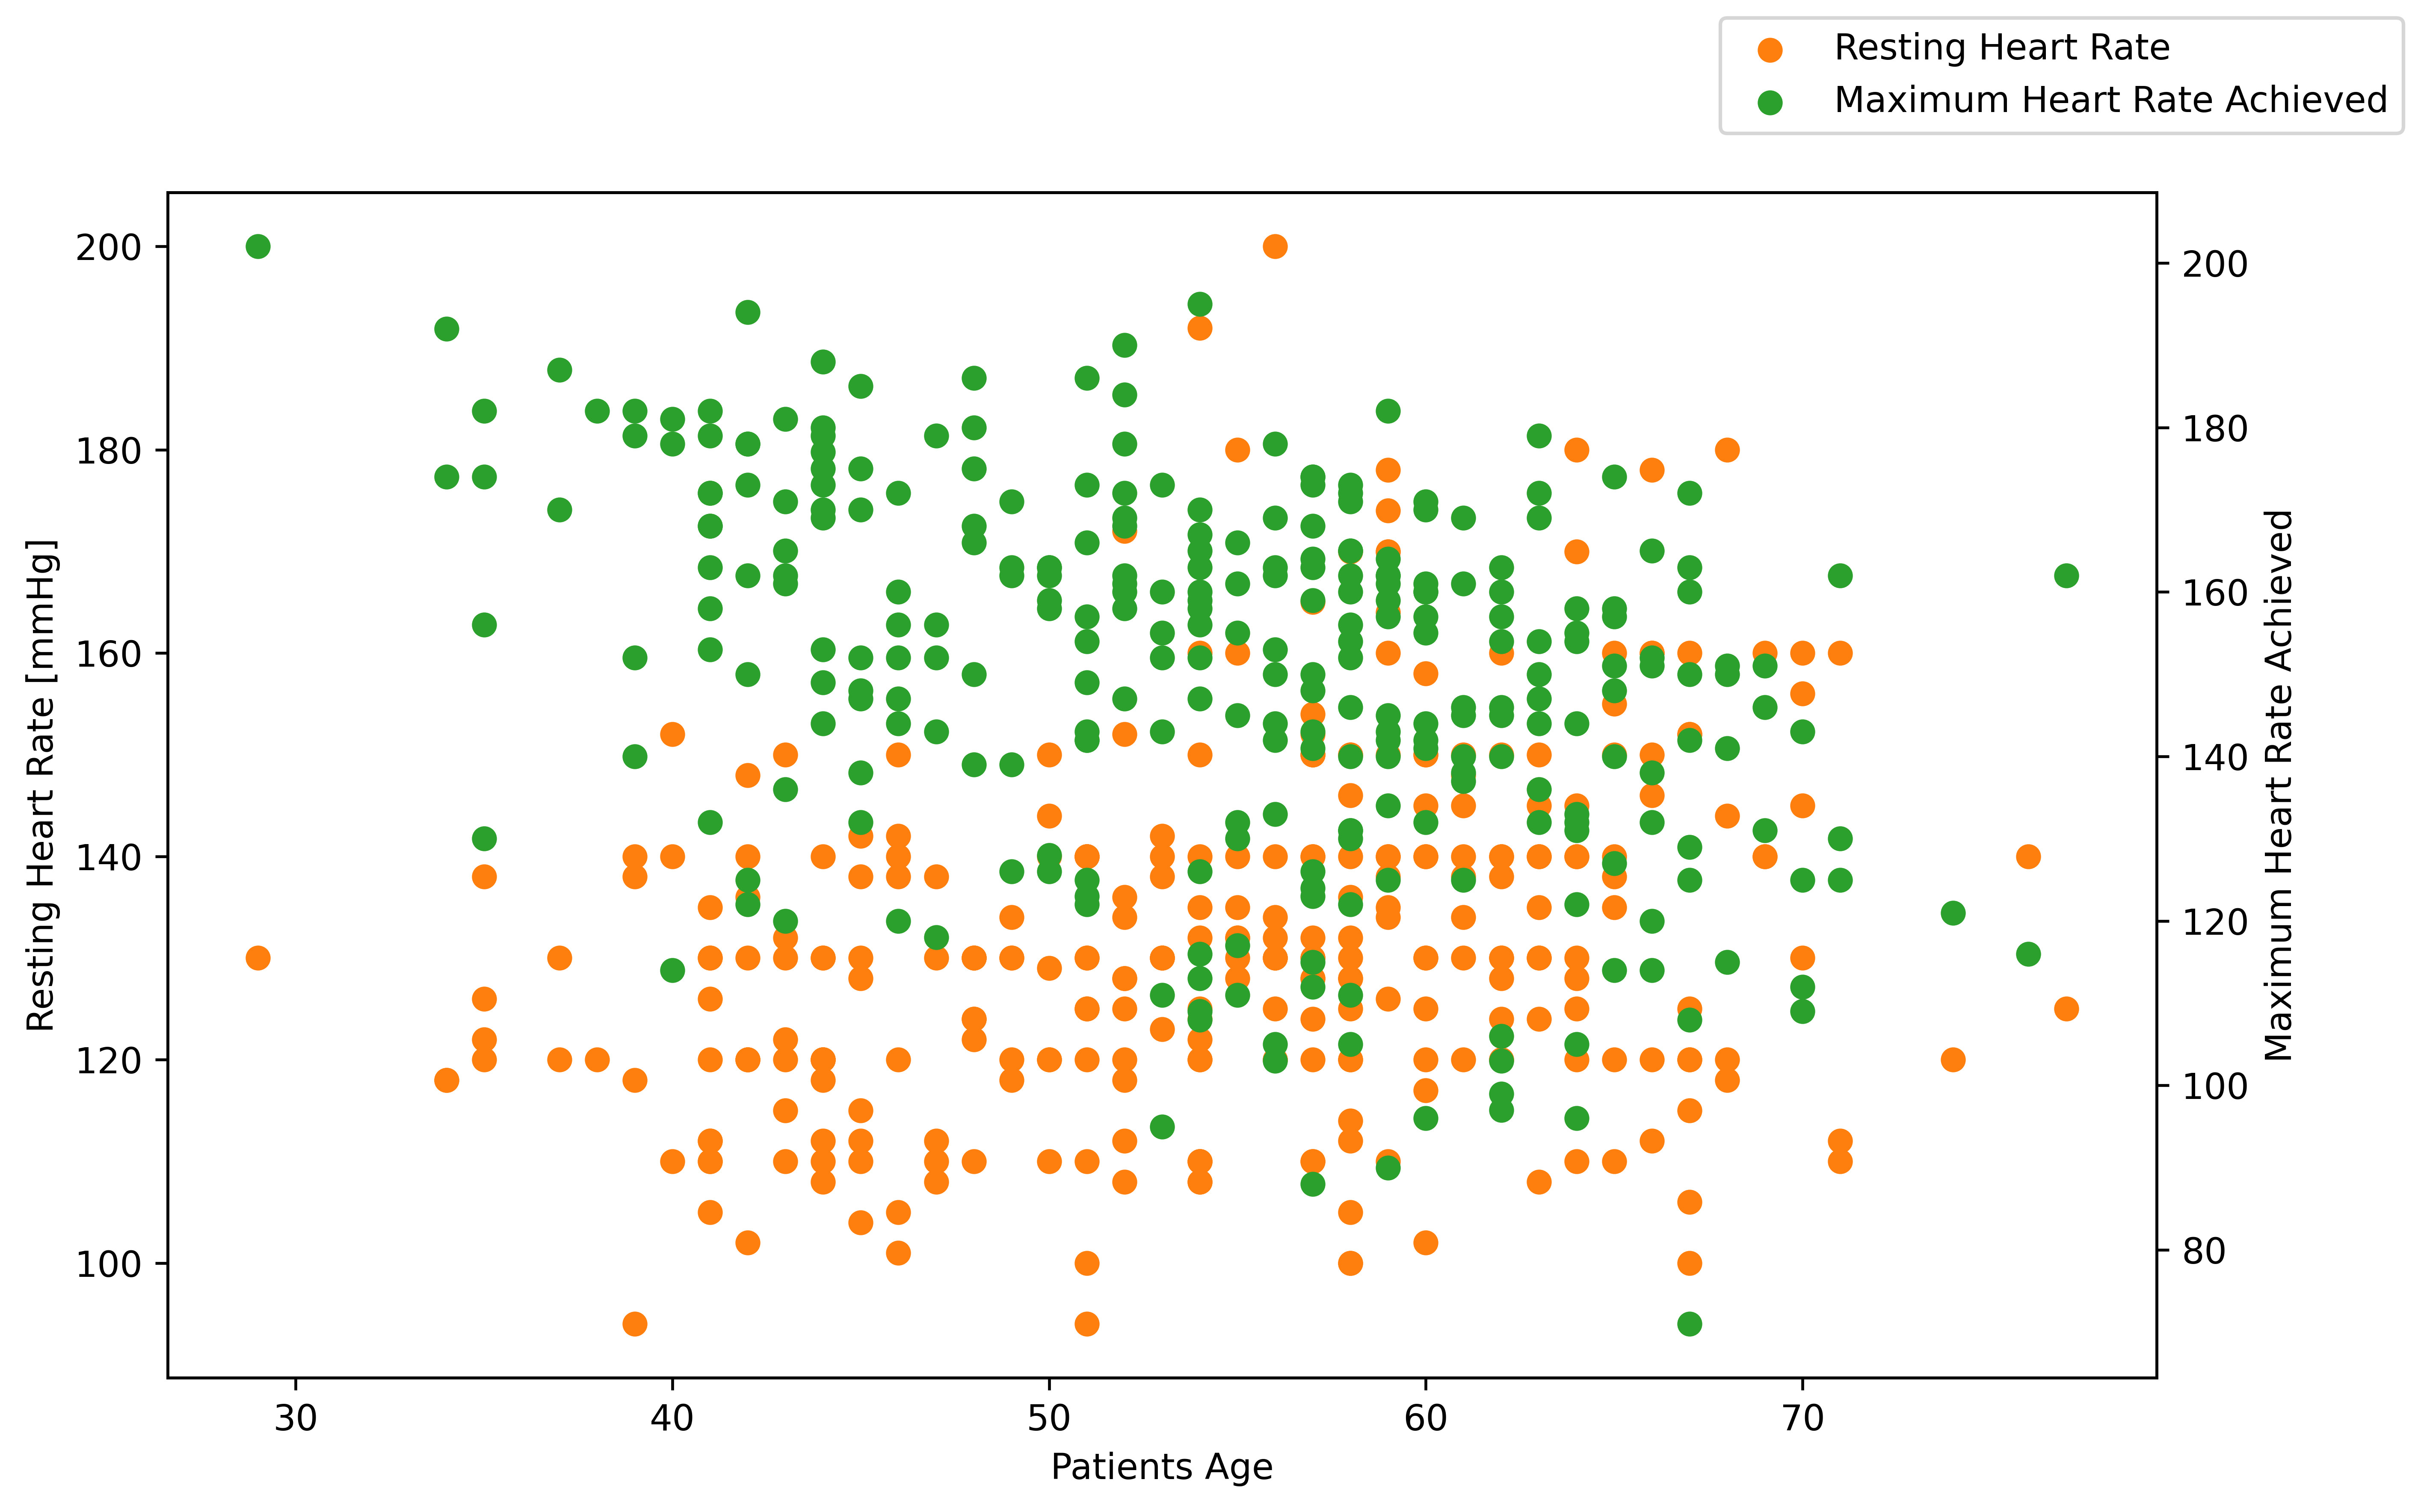

In [4]:
fig, ax = plt.subplots(figsize= (10, 6))
ax1 = ax.twinx()
ax.scatter(
    x= df["age"],
    y= df["trestbps"],
    c= "tab:orange",
    label="Resting Heart Rate"
)
ax1.scatter(
    x= df["age"],
    y= df["thalach"],
    c= "tab:green",
    label= "Maximum Heart Rate Achieved"
)

ax.set_xlabel("Patients Age")
ax.set_ylabel("Resting Heart Rate [mmHg]")
ax1.set_ylabel("Maximum Heart Rate Achieved")
fig.set_dpi(600)
fig.legend()


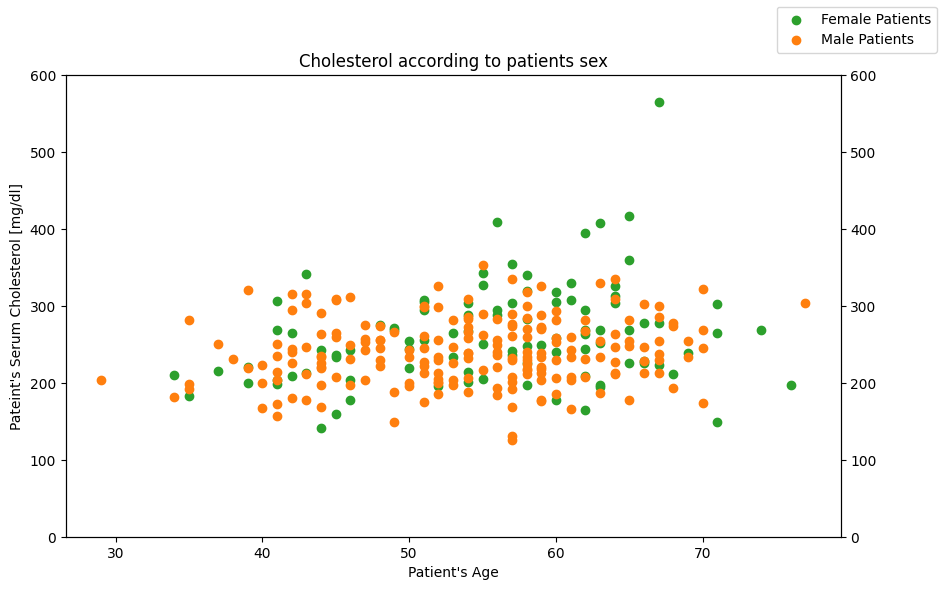

In [5]:
sex_idxs = {"female": [], "male": []}
for idx in range(len(df)):
    if df["sex"][idx] == 0:
        sex_idxs["female"].append(idx)
    else:
        sex_idxs["male"].append(idx)


fig, ax = plt.subplots(figsize=(10, 6))
ax1 = ax.twinx()
ax.scatter(
    x=df["age"][sex_idxs["female"]],
    y=df["chol"][sex_idxs["female"]],
    color= "tab:green",
    label= "Female Patients"
)
ax1.scatter(
    x= df["age"][sex_idxs["male"]],
    y= df["chol"][sex_idxs["male"]],
    color= "tab:orange",
    label= "Male Patients"
)
ax.set_title(f"Cholesterol according to patients sex")
ax.set_xlabel("Patient's Age")
ax.set_ylabel("Pateint's Serum Cholesterol [mg/dl]")
ax.set_ylim(bottom=0, top=600)
ax1.set_ylim(bottom=0, top=600)
fig.legend()

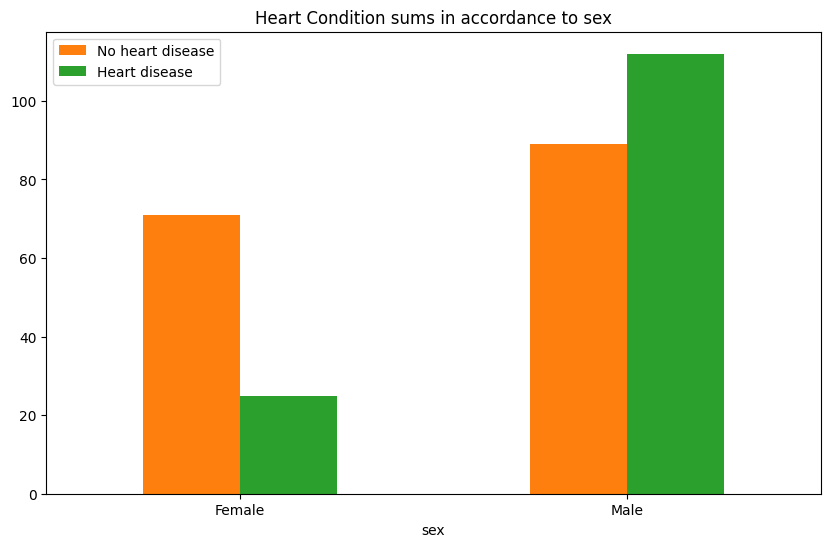

In [6]:
pd.crosstab(df["sex"], df["condition"]).plot(kind="bar", figsize=(10, 6), color=["tab:orange", "tab:green"])
plt.legend(["No heart disease", "Heart disease"])
plt.xticks(ticks=[0, 1], labels=["Female", "Male"], rotation="horizontal")
plt.title("Heart Condition sums in accordance to sex");

Now that we explored the data a little bit we can see some patterns emerging - men suffer from heart conditions more often than women. Also male cholesterol levels vary less with age, but they tend to be high, while in female cholesterol there are a few outliers but the results are on the lower end. Now that we know a bit about the data set it's time to start dividing data!

## <u>Preparing data for training</u>

### Creating Train and Test sets

Since we are dealing with a rather small dataset to begin with diluting it even more doesn't make much sense. I will start with setting up the random seed, so that the results are reproducable. Then we will divide the DataFrame into train and test sets in a 0.7:0.3 ratio with the help of `train_test_split()`.

In [7]:
# Setting up the random seed
funcs.set_seed()

# Creating X and y DataFrames
X = df.drop("condition", axis=1)
y = df["condition"]

# Dividing data into train and test set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)
len(X_train), len(X_test), len(y_train), len(y_test)

(207, 90, 207, 90)

In [8]:
y_train.value_counts()

condition
0    112
1     95
Name: count, dtype: int64

In [9]:
y_test.value_counts()

condition
0    48
1    42
Name: count, dtype: int64

### Putting data into batches

Interestingly enough I will skip it this time around - in the `IdentiBreed` <a href="https://github.com/Ale-Cie/IdentiBreed">notebooks</a> I created a function that divided the data into batches before training but now I want to try training and setting up the `batch_size` when setting the training function up.

## Building the network

I am going to start by creating a rather simple `keras.Sequential()` network that will look a little like the graph below:

<img src="https://aleksanderc.pythonanywhere.com/static/images/Projects/Notebooks/hdp_blueprint.png" style="width: 400px">

As you can see the first iteration of the network is going to be really straight forward, as it will consist of:
 - <b>BatchNormalization Input Layer</b> with size set to the number of features;
 - <b>Dense Hidden Layer</b> with 10 nodes and "relu" activation function
 - <b>Droput Hidden Layer</b> with the dropout rate of 0.3
 - <b>Dense Output Layer</b> with 1 input for each row of patient parameters and "sigmoid" activation function 

This way my network will preprocess the data, run it thorugh a layer of nodes which will have some of the connections terminated in order to prevent overfitting and then a prediction will be given. I will also create two callbacks - `EarlyStopping` and `ReduceLROnPlateau`. Let's stop talking now and get to setting up the network.


### Creating Callbacks

In [10]:
# Let's begin with defining the input_shape and making my code a little bit cleaner with the declartaion of what layers stand for
layers = tf.keras.layers
input_shape = [X_train.shape[1]]

# Now I will define the callbacks
# Let's begin with the EarlyStopping callback

early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor= "val_loss",
    patience= 5,
    restore_best_weights= True
)

# And now ReduceLROnPlateau

reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(
    monitor= "val_loss",
    factor= 0.1,
    min_lr= 0.001,
    patience= 5,
)

# We don't have to create a tensorboard callback, since it's already defined in the funcs.py
tensorboard_callback = funcs.tensorboard_callback()

### Creating the network's structure

In [11]:
# Now let's get on with the model creation
model_1 = keras.Sequential([
   layers.BatchNormalization(
      input_shape= input_shape,
      name= "Input_Layer"
      ),
   layers.Dense(
       units= 10,
       activation= "relu",
       name= "Hidden_Dense_Layer"
   ),
   layers.Dropout(
       rate= 0.3,
       name= "Hidden_Dropout_Layer"
   ),
   layers.Dense(
       units= 1,
       activation= "sigmoid",
       name= "Output_Layer"
   )
])

model_1.summary()

Metal device set to: Apple M1

systemMemory: 8.00 GB
maxCacheSize: 2.67 GB

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input_Layer (BatchNormaliza  (None, 13)               52        
 tion)                                                           
                                                                 
 Hidden_Dense_Layer (Dense)  (None, 10)                140       
                                                                 
 Hidden_Dropout_Layer (Dropo  (None, 10)               0         
 ut)                                                             
                                                                 
 Output_Layer (Dense)        (None, 1)                 11        
                                                                 
Total params: 203
Trainable params: 177
Non-trainable params: 26
_______________________________________________

### Training the network

In [12]:
# Before moving on with training I have to select optimizer, loss and metrics
model_1.compile(
    optimizer= "adam",
    loss= "binary_crossentropy",
    metrics= ["binary_accuracy"],
)

# Since everything seems done I can go on and start training the model on the X_train and y_train sets
model_1.fit(
    x= X_train,
    y= y_train,
    validation_split= 0.25,
    batch_size= 20,
    epochs= 200,
    callbacks= [early_stopping, reduce_lr],
    verbose= True
)

Epoch 1/200


2023-09-16 13:15:26.478165: W tensorflow/tsl/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


8/8 [==============================] - 1s 70ms/step - loss: 0.9455 - binary_accuracy: 0.4129 - val_loss: 5.4266 - val_binary_accuracy: 0.4808 - lr: 0.0010
Epoch 2/200
8/8 [==============================] - 0s 14ms/step - loss: 0.8643 - binary_accuracy: 0.5032 - val_loss: 3.8589 - val_binary_accuracy: 0.4808 - lr: 0.0010
Epoch 3/200
8/8 [==============================] - 0s 17ms/step - loss: 0.8764 - binary_accuracy: 0.5419 - val_loss: 3.1711 - val_binary_accuracy: 0.4808 - lr: 0.0010
Epoch 4/200
8/8 [==============================] - 0s 14ms/step - loss: 0.7768 - binary_accuracy: 0.5871 - val_loss: 2.7691 - val_binary_accuracy: 0.4808 - lr: 0.0010
Epoch 5/200
8/8 [==============================] - 0s 15ms/step - loss: 0.7579 - binary_accuracy: 0.5677 - val_loss: 2.4690 - val_binary_accuracy: 0.4808 - lr: 0.0010
Epoch 6/200
8/8 [==============================] - 0s 14ms/step - loss: 0.6336 - binary_accuracy: 0.6903 - val_loss: 2.2238 - val_binary_accuracy: 0.4808 - lr: 0.0010
Epoch 7/20

### Scoring the network's accuracy

Now that this simple network has been trained we can go on and score it on the test set. In order to do so I have defined a simple function that takes the predictions (list of arrays) and the true_values (the y_test set). It turns the floating point numbers from the predictions into labels - because of the "sigmoid" activation the predictions are between 0 and 1. That's why < 0.5 means the model believes it's the 0 label, and >= 0.5 is 1 and append them to an ordered list. Then, the function keeps track of how many predictions were correct and in the very end returns the score (correct predictions/all labels). 

In [13]:
# We start by making predictions and displaying them to see what we are dealing with
predictions = model_1.predict(
    x= X_test,
    batch_size= 20
)

print(predictions)

5/5 [==============================] - 0s 11ms/step
[[0.9301008 ]
 [0.85468435]
 [0.10620348]
 [0.01769232]
 [0.5787831 ]
 [0.16686904]
 [0.9935592 ]
 [0.9859497 ]
 [0.94516814]
 [0.12141797]
 [0.3106214 ]
 [0.8153121 ]
 [0.16948073]
 [0.03787223]
 [0.05827873]
 [0.6721624 ]
 [0.768457  ]
 [0.09101065]
 [0.9348526 ]
 [0.04273985]
 [0.8747462 ]
 [0.8450312 ]
 [0.05403673]
 [0.05328164]
 [0.12345382]
 [0.9382964 ]
 [0.9739726 ]
 [0.9959798 ]
 [0.36970267]
 [0.7035827 ]
 [0.7989398 ]
 [0.9538218 ]
 [0.4263616 ]
 [0.25941032]
 [0.67026687]
 [0.99451715]
 [0.5408762 ]
 [0.12556167]
 [0.9849637 ]
 [0.07316062]
 [0.05336012]
 [0.7428189 ]
 [0.628686  ]
 [0.19264476]
 [0.12132204]
 [0.93677247]
 [0.1292891 ]
 [0.93269503]
 [0.77657765]
 [0.07142098]
 [0.5591965 ]
 [0.72884196]
 [0.09849585]
 [0.5784781 ]
 [0.98336226]
 [0.5013512 ]
 [0.18485148]
 [0.90993184]
 [0.268067  ]
 [0.7005633 ]
 [0.98621494]
 [0.63833123]
 [0.10088204]
 [0.02039761]
 [0.9895219 ]
 [0.03607634]
 [0.06089635]
 [0.961672

In [14]:
# Now that we know what the 'predictions' variable is (a list of arrays) we need to see what does the y_test look like
print(y_test)

167    1
211    1
63     0
154    0
5      0
      ..
15     0
10     1
228    1
184    1
68     0
Name: condition, Length: 90, dtype: int64


In [15]:
score = funcs.score_model(
    predictions= predictions, 
    true_values= y_test
)

funcs.close_session()

print("The model's accuracy is %.3f" %(score*100) + "%")

The model's accuracy is 84.444%


## Saving the network and preparing for experimentation

First iteration of this network performs quite nicely. Let's save it just for preservations sake and focus on experimenting. In order to save the function I will utilise the `save_network()` function from funcs.py.

In [16]:
# funcs.save_network(
#     model= model_1,
#     name= "Network_v1"
# )

## External Experimentation

In order to keep this notebook easier to follow and clutter-free I decided to perform the first experimentations externally. On the projects GitHub page you can see the <a href="https://github.com/Ale-Cie/heart_disease_project/blob/main/external_experimentation.ipynb">`external_experimentation.ipynb`</a> notebook. Inside of it I take the structure of the `model_1` and try out what follows:

- I change the value of units in the Hidden Dense Layer (`model_2`)
- I add another Hidden Dense Layer (`model_3`)
- I try training five different variations of `model_3` with different dropout rates (`model_3_1`)
- I expand the `model_1` structure with two new Dense layers, two new Dropout layers and a BatchNormalization layer (`model_4`)
- I try training five different variations of `model_4` with different dropout rates (`model_4_1`)

In the end I found three models did best and those were:

- `model_1` (the base model present in this notebook already)
- `model_2`
- `model_4_1`

Next step is retrieving the parameters of each of these networks and setting them up here.

### Top parameters

Thanks to the last cell in the `external_experimentation.ipynb` notebook we have the models as well as the parameters saved! We can now import all of them, chech their summaries and rebuild these models from the ground up.

In [17]:
# Let's start by importing the models and then loading in all the parameters

model_2 = tf.keras.models.load_model("./model_v2_20230816-190757.h5")
model_4_1 = tf.keras.models.load_model("./model_v4_1_20230816-190757.h5")

params_list = [line.replace(" ", "") for line in open("./model_params.txt", "r").readlines()]

params_dict = {}
for line in params_list:
    key, value = line.replace("\n", "").split(":")
    params_dict[key] = eval(value)

print(params_dict)

{'model_1_params': (10, 0.3), 'model_2_params': (13, 0.3), 'model_4_1_best_params': (13, 10, 7, 0.2, 0.3, 0.3)}


In [18]:
model_2.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 batch_normalization (BatchN  (None, 13)               52        
 ormalization)                                                   
                                                                 
 dense (Dense)               (None, 13)                182       
                                                                 
 dropout (Dropout)           (None, 13)                0         
                                                                 
 dense_1 (Dense)             (None, 1)                 14        
                                                                 
Total params: 248
Trainable params: 222
Non-trainable params: 26
_________________________________________________________________


In [19]:
model_4_1.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 IL_20230816-190739 (BatchNo  (None, 13)               52        
 rmalization)                                                    
                                                                 
 HDL1_20230816-190739 (Dense  (None, 13)               182       
 )                                                               
                                                                 
 HDpL1_20230816-190739 (Drop  (None, 13)               0         
 out)                                                            
                                                                 
 HBNL_20230816-190739 (Batch  (None, 13)               52        
 Normalization)                                                  
                                                                 
 HDL2_20230816-190739 (Dense  (None, 10)               1

Let's score these models once again and then get to working on their performances

In [20]:
funcs.set_seed()
funcs.close_session()

model_2_score = funcs.score_model(
    predictions= model_2.predict(
        x= X_test,
        batch_size= 20,
        verbose= False
    ),
    true_values= y_test
)

model_4_1_score = funcs.score_model(
    predictions= model_4_1.predict(
        x= X_test,
        batch_size= 20,
        verbose= False
    ),
    true_values= y_test
)

print("Model_2 accuracy score equals to %.3f" %(model_2_score * 100) + "%")
print("Model_4_1 accuracy score equals to %.3f" %(model_4_1_score * 100) + "%")

Model_2 accuracy score equals to 82.222%
Model_4_1 accuracy score equals to 81.111%


## Internal Experimentation

### model_2

Now it's time to experiment a bit with both imported models. We will start with `model_2` by tweaking the `units` and `rate`. No point in talking, let's get to work!

First step will be experimenting with the rates

In [21]:
model_2_rates = []

for rate in np.arange(0.2, 0.4, 0.015):
    model_2_rates.append((13, rate))

print(model_2_rates)

[(13, 0.2), (13, 0.21500000000000002), (13, 0.23000000000000004), (13, 0.24500000000000005), (13, 0.26000000000000006), (13, 0.2750000000000001), (13, 0.2900000000000001), (13, 0.3050000000000001), (13, 0.3200000000000001), (13, 0.33500000000000013), (13, 0.35000000000000014), (13, 0.36500000000000016), (13, 0.38000000000000017), (13, 0.3950000000000002)]


In [22]:
# Before we go any further let's make our lives a little easier

callbacks = [early_stopping, reduce_lr]

datasets = [X_train, X_test, y_train, y_test]

In [23]:
model_2_1_dict = funcs.network_dict(
    input_shape= input_shape,
    params_list= model_2_rates,
    callbacks= callbacks,
    data= datasets,
    iteration= 2
)

for key, value in model_2_1_dict.items():
    print(f"{key} accuracy equals: {value[1]}%")

Scoring model 1/14
5/5 [==============================] - 0s 4ms/step
Scoring model 2/14
5/5 [==============================] - 0s 4ms/step
Scoring model 3/14
5/5 [==============================] - 0s 5ms/step
Scoring model 4/14
5/5 [==============================] - 0s 4ms/step
Scoring model 5/14
5/5 [==============================] - 0s 8ms/step
Scoring model 6/14
5/5 [==============================] - 0s 4ms/step
Scoring model 7/14
5/5 [==============================] - 0s 3ms/step
Scoring model 8/14
5/5 [==============================] - 0s 6ms/step
Scoring model 9/14
5/5 [==============================] - 0s 4ms/step
Scoring model 10/14
5/5 [==============================] - 0s 5ms/step
Scoring model 11/14
5/5 [==============================] - 0s 5ms/step
Scoring model 12/14
5/5 [==============================] - 0s 5ms/step
Scoring model 13/14
5/5 [==============================] - 0s 5ms/step
Scoring model 14/14
5/5 [==============================] - 0s 5ms/step
Done scoring!
M

Since the output is truncated let's create a bar graph representing all the scores and see which iteration did the best

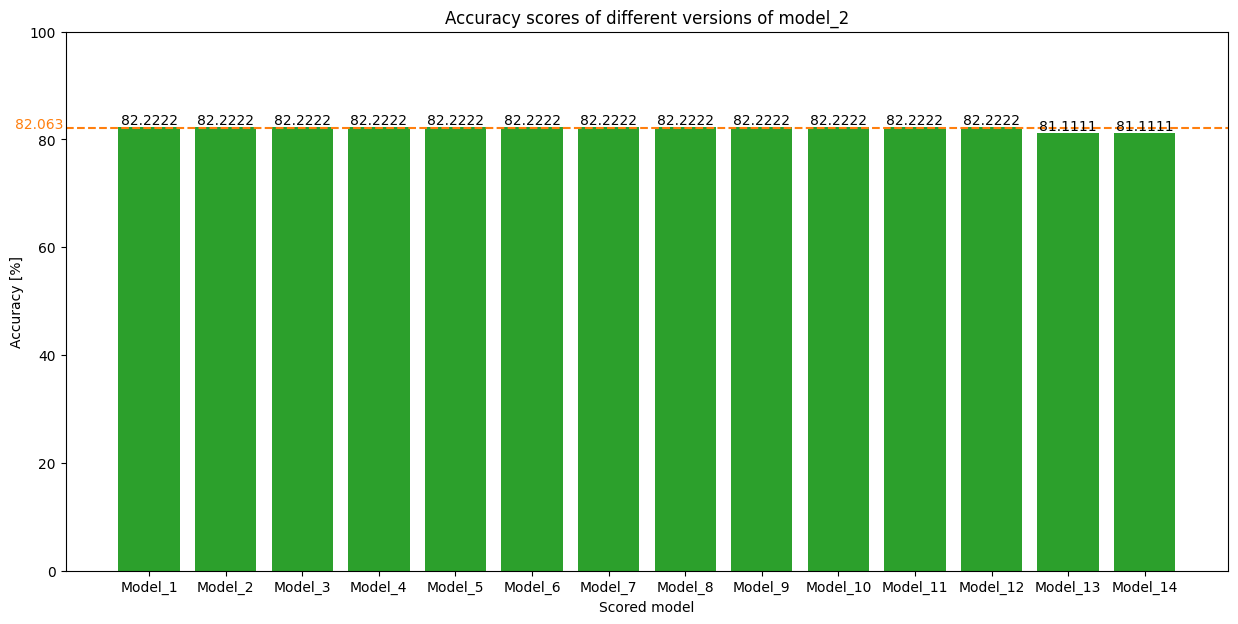

In [24]:
fig, ax = plt.subplots(figsize=(15, 7))

ax.bar(
    x= [key for key in model_2_1_dict.keys()],
    height= [value[1] for value in model_2_1_dict.values()],
    color= "tab:green"
)

ax.set_ylabel("Accuracy [%]")
ax.set_xlabel("Scored model")
ax.set_title("Accuracy scores of different versions of model_2")
ax.set_ylim(0, 100)
plt.axhline(y=np.mean([value[1] for value in model_2_1_dict.values()]), color="tab:orange", linestyle="--", label=f"{np.mean([value[1] for value in model_2_1_dict.values()])}")
ax.text(
    x= -1.75,
    y= np.mean([value[1] for value in model_2_1_dict.values()]),
    s= "%.3f" % np.mean([value[1] for value in model_2_1_dict.values()]),
    fontdict= {"color": "tab:orange"}
)
for container in ax.containers:
    ax.bar_label(container)


Now that's a bit interesting - apparently changing rates and leaving the units at 13 doesn't really affect the networks performance that much. Let's do a one more go with the changed rates, but this time they will go from 0.4 to 0.5 

Scoring model 1/10
5/5 [==============================] - 0s 11ms/step
Scoring model 2/10
5/5 [==============================] - 0s 7ms/step
Scoring model 3/10
5/5 [==============================] - 0s 8ms/step
Scoring model 4/10
5/5 [==============================] - 0s 7ms/step
Scoring model 5/10
5/5 [==============================] - 0s 7ms/step
Scoring model 6/10
5/5 [==============================] - 0s 11ms/step
Scoring model 7/10
5/5 [==============================] - 0s 15ms/step
Scoring model 8/10
5/5 [==============================] - 0s 18ms/step
Scoring model 9/10
5/5 [==============================] - 0s 8ms/step
Scoring model 10/10
5/5 [==============================] - 0s 10ms/step
Done scoring!


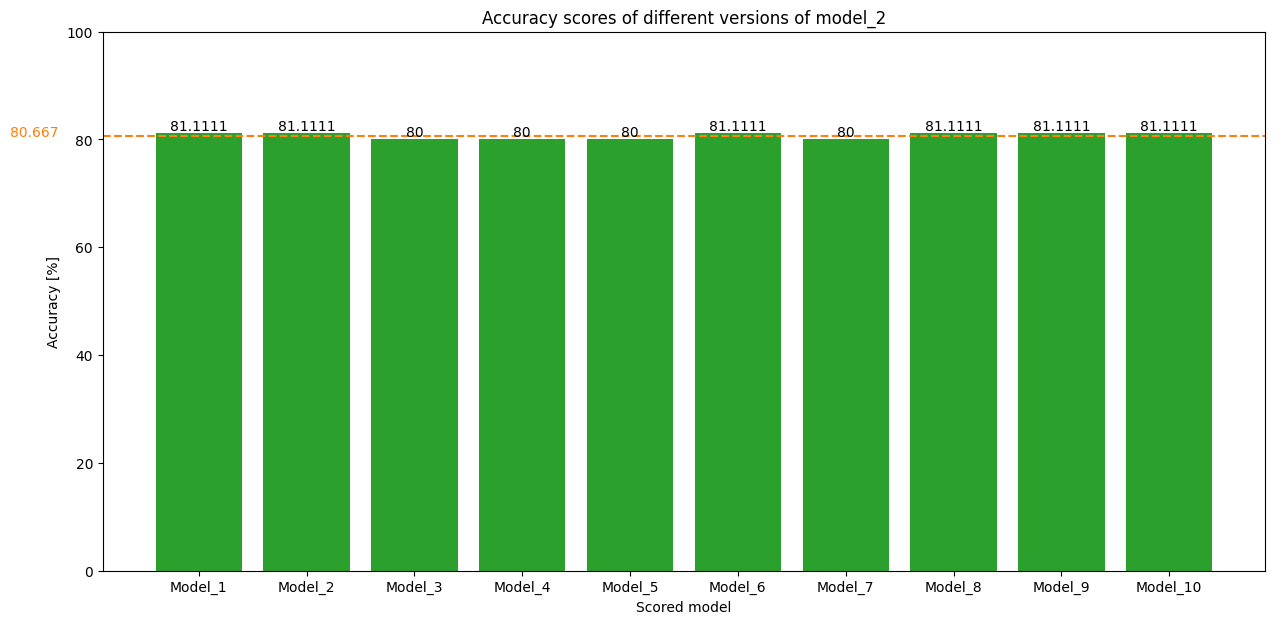

In [25]:
model_2_2_rates = []

for rate in np.arange(0.4, 0.5, 0.01):
    model_2_2_rates.append((13, rate))

model_2_2_dict = funcs.network_dict(
    input_shape= input_shape,
    params_list= model_2_2_rates,
    callbacks= callbacks,
    data= datasets,
    iteration= 2
)

fig, ax = plt.subplots(figsize=(15, 7))

ax.bar(
    x= [key for key in model_2_2_dict.keys()],
    height= [value[1] for value in model_2_2_dict.values()],
    color= "tab:green"
)

ax.set_ylabel("Accuracy [%]")
ax.set_xlabel("Scored model")
ax.set_title("Accuracy scores of different versions of model_2")
ax.set_ylim(0, 100)
plt.axhline(y=np.mean([value[1] for value in model_2_2_dict.values()]), color="tab:orange", linestyle="--", label=f"{np.mean([value[1] for value in model_2_2_dict.values()])}")
ax.text(
    x= -1.75,
    y= np.mean([value[1] for value in model_2_2_dict.values()]),
    s= "%.3f" % np.mean([value[1] for value in model_2_2_dict.values()]),
    fontdict= {"color": "tab:orange"}
)
for container in ax.containers:
    ax.bar_label(container)

Well, seeing as this lowered the models performance it just calls to me to check now a dropout rate range from 0.1 to 0.2... let's give it a go because why not.

Scoring model 1/19


5/5 [==============================] - 0s 6ms/step
Scoring model 2/19
5/5 [==============================] - 0s 8ms/step
Scoring model 3/19
5/5 [==============================] - 0s 7ms/step
Scoring model 4/19
5/5 [==============================] - 0s 17ms/step
Scoring model 5/19
5/5 [==============================] - 0s 8ms/step
Scoring model 6/19
5/5 [==============================] - 0s 10ms/step
Scoring model 7/19
5/5 [==============================] - 0s 7ms/step
Scoring model 8/19
5/5 [==============================] - 0s 7ms/step
Scoring model 9/19
5/5 [==============================] - 0s 7ms/step
Scoring model 10/19
5/5 [==============================] - 0s 11ms/step
Scoring model 11/19
5/5 [==============================] - 0s 10ms/step
Scoring model 12/19
5/5 [==============================] - 0s 13ms/step
Scoring model 13/19
5/5 [==============================] - 0s 9ms/step
Scoring model 14/19
5/5 [==============================] - 0s 8ms/step
Scoring model 15/19
5/5 [====

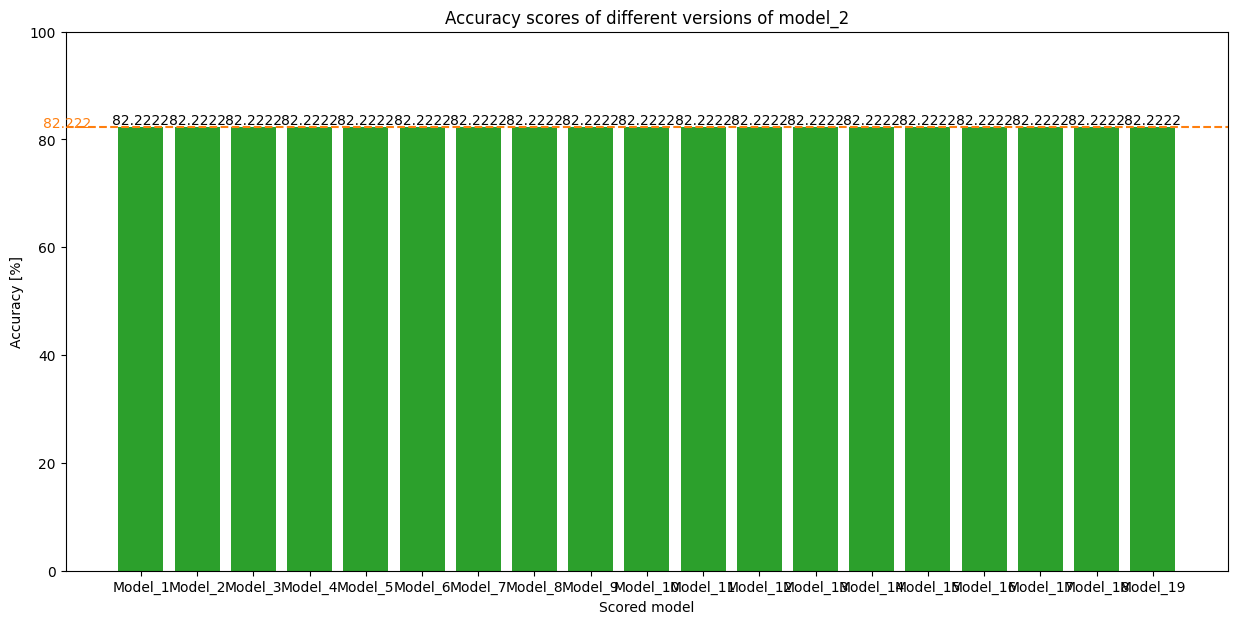

In [26]:
model_2_3_rates = []

for rate in np.arange(0.01, 0.2, 0.01):
    model_2_3_rates.append((13, rate))

model_2_3_dict = funcs.network_dict(
    input_shape= input_shape,
    params_list= model_2_3_rates,
    callbacks= callbacks,
    data= datasets,
    iteration= 2
)

fig, ax = plt.subplots(figsize=(15, 7))

ax.bar(
    x= [key for key in model_2_3_dict.keys()],
    height= [value[1] for value in model_2_3_dict.values()],
    color= "tab:green"
)

ax.set_ylabel("Accuracy [%]")
ax.set_xlabel("Scored model")
ax.set_title("Accuracy scores of different versions of model_2")
ax.set_ylim(0, 100)
plt.axhline(y=np.mean([value[1] for value in model_2_3_dict.values()]), color="tab:orange", linestyle="--", label=f"{np.mean([value[1] for value in model_2_3_dict.values()])}")
ax.text(
    x= -1.75,
    y= np.mean([value[1] for value in model_2_3_dict.values()]),
    s= "%.3f" % np.mean([value[1] for value in model_2_3_dict.values()]),
    fontdict= {"color": "tab:orange"}
)
for container in ax.containers:
    ax.bar_label(container)

This graph needs a bit of cleaning up which I think I'll pass on... Honestly I see that it looks like we could experiment with numbers of units. We know now that with a 10 we will get greater performance (`model_1`) but what about other values, say from 5 to 20? 

Scoring model 1/16
5/5 [==============================] - 0s 18ms/step
Scoring model 2/16
5/5 [==============================] - 0s 9ms/step
Scoring model 3/16
5/5 [==============================] - 0s 21ms/step
Scoring model 4/16
5/5 [==============================] - 0s 13ms/step
Scoring model 5/16
5/5 [==============================] - 0s 13ms/step
Scoring model 6/16
5/5 [==============================] - 0s 12ms/step
Scoring model 7/16
5/5 [==============================] - 0s 14ms/step
Scoring model 8/16
5/5 [==============================] - 0s 19ms/step
Scoring model 9/16
5/5 [==============================] - 0s 21ms/step
Scoring model 10/16
5/5 [==============================] - 0s 15ms/step
Scoring model 11/16
5/5 [==============================] - 0s 22ms/step
Scoring model 12/16
5/5 [==============================] - 0s 45ms/step
Scoring model 13/16
5/5 [==============================] - 0s 22ms/step
Scoring model 14/16
5/5 [==============================] - 0s 13ms/step
Sc

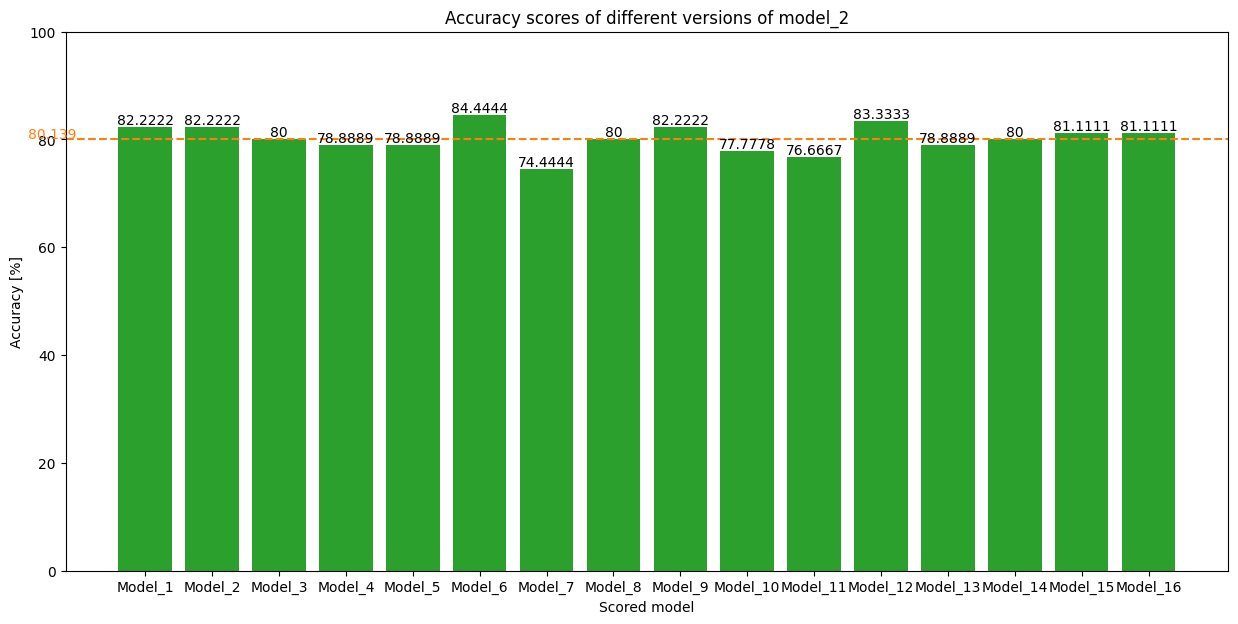

In [27]:
model_2_4_units = []

for units in range(5, 21):
    model_2_4_units.append((units, 0.3))

model_2_4_dict = funcs.network_dict(
    input_shape= input_shape,
    params_list= model_2_4_units,
    callbacks= callbacks,
    data= datasets,
    iteration= 2
)

fig, ax = plt.subplots(figsize=(15, 7))

ax.bar(
    x= [key for key in model_2_4_dict.keys()],
    height= [value[1] for value in model_2_4_dict.values()],
    color= "tab:green"
)

ax.set_ylabel("Accuracy [%]")
ax.set_xlabel("Scored model")
ax.set_title("Accuracy scores of different versions of model_2")
ax.set_ylim(0, 100)
plt.axhline(y=np.mean([value[1] for value in model_2_4_dict.values()]), color="tab:orange", linestyle="--")
ax.text(
    x= -1.75,
    y= np.mean([value[1] for value in model_2_4_dict.values()]),
    s= "%.3f" % np.mean([value[1] for value in model_2_4_dict.values()]),
    fontdict= {"color": "tab:orange"}
)
for container in ax.containers:
    ax.bar_label(container)

Well we have two winners in this experiemnt - `Model_6` (which I'm sure is the same setup as the original `model_1` but we will check shortly) and `Model_12` - it did better than the original `model_2`, so maybe we could utilise the units in any of the future iterations of this network.

In [28]:
# Let's just check the value of units in this particular model, and then let's get going with the second imported model

print(model_2_4_units[6-1]), print(model_2_4_units[12-1])

(10, 0.3)
(16, 0.3)


(None, None)

### model_4_1

Let's get going with the training. We will use the `network_dict()` function with the `iteration` argument set to 4. We have to provide parameter tuples that consist of - units1, units2, units3, rate1, rate2, rate3. I don't think I will experiment with the rates that much, mainly I will focus on different units.

In [29]:
funcs.set_seed()
model_4_1_params = []

units1 = (10, 13, 16, 19)

for unit in units1:
    for i in range(0, 7):
        units_2n3 = sorted((np.random.randint(7, unit), np.random.randint(7, unit)))[::-1]
        rates = []
        for rate in np.random.random_sample((3, ),):
            if rate > 0.5:
                rates.append(rate - 0.45)
            elif rate < 0.25:
                rates.append(rate + 0.11)
            else:
                rates.append(rate)
        
        rates = sorted(rates)[::-1]
            
        model_4_1_params.append((unit, units_2n3[0], units_2n3[1], rates[0], rates[1], rates[2]))

print(model_4_1_params)

[(10, 9, 7, 0.32969100027276926, 0.2934347898661638, 0.14685015794648698), (10, 9, 8, 0.45924889196586716, 0.33370861113902184, 0.20997491581800287), (10, 9, 8, 0.48855270901575015, 0.27199877226682473, 0.16641157902710024), (10, 8, 7, 0.16748150962771652, 0.16165316048828088, 0.1170663052197174), (10, 7, 7, 0.3998609717152555, 0.1566656632136154, 0.07477466025838914), (10, 9, 8, 0.38246199126716274, 0.2006064345328208, 0.16838600933308728), (10, 9, 7, 0.450499251969543, 0.40994040673632054, 0.2303075385877797), (13, 10, 8, 0.49220175568485275, 0.3854165025399161, 0.11328821784553927), (13, 11, 8, 0.3510254660260117, 0.340893825622149, 0.2332635188254582), (13, 11, 10, 0.3910606075732408, 0.3831949117361643, 0.28336465350777207), (13, 10, 8, 0.31171107608941095, 0.09671027934327964, 0.0700680211778108), (13, 12, 11, 0.5195846277645586, 0.4894989415641891, 0.32513282336111454), (13, 12, 10, 0.4718742350231168, 0.19849250205191948, 0.14789997881108513), (13, 10, 7, 0.5111720243493492, 0.

Now we're left with a list of 28 sets of parameters. I'm not saying they are all different, since I made no effort to assure that, but due to the random nature of the floating points it's highly unlikely that there are any doubles. Let's create a network dict and see how long does it take to train them.

Scoring model 1/28


5/5 [==============================] - 0s 24ms/step
Scoring model 2/28
5/5 [==============================] - 0s 34ms/step
Scoring model 3/28
5/5 [==============================] - 0s 23ms/step
Scoring model 4/28
5/5 [==============================] - 0s 20ms/step
Scoring model 5/28
5/5 [==============================] - 0s 31ms/step
Scoring model 6/28
5/5 [==============================] - 0s 32ms/step
Scoring model 7/28
5/5 [==============================] - 0s 32ms/step
Scoring model 8/28
5/5 [==============================] - 0s 28ms/step
Scoring model 9/28
5/5 [==============================] - 0s 41ms/step
Scoring model 10/28
5/5 [==============================] - 0s 45ms/step
Scoring model 11/28
5/5 [==============================] - 0s 25ms/step
Scoring model 12/28
5/5 [==============================] - 0s 36ms/step
Scoring model 13/28
5/5 [==============================] - 0s 32ms/step
Scoring model 14/28
5/5 [==============================] - 0s 37ms/step
Scoring model 15/28


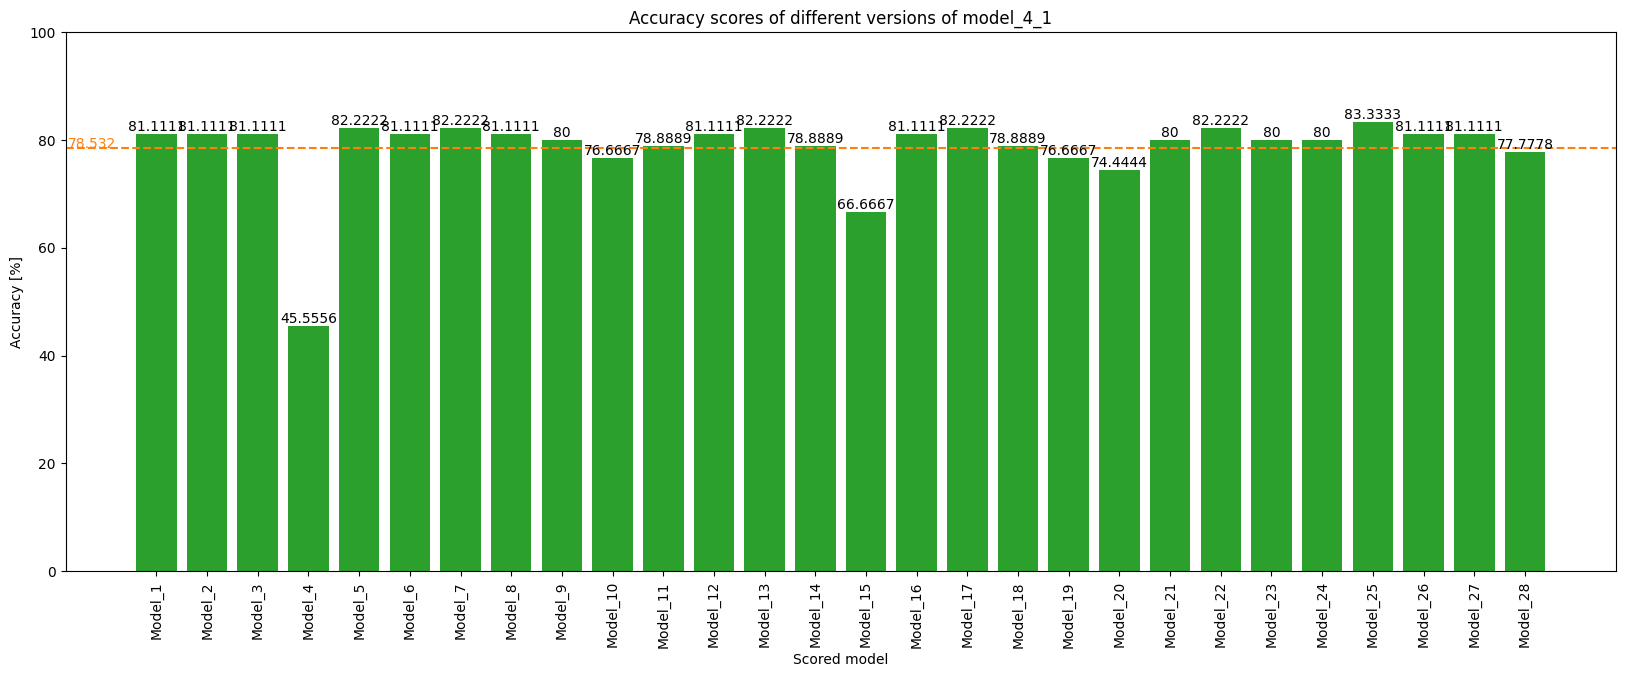

In [30]:
funcs.set_seed()
funcs.close_session()

model_4_2_dict = funcs.network_dict(
    input_shape= input_shape,
    params_list= model_4_1_params,
    callbacks= callbacks,
    data= datasets,
    iteration= 4
)

fig, ax = plt.subplots(figsize=(20, 7))

ax.bar(
    x= [key for key in model_4_2_dict.keys()],
    height= [value[1] for value in model_4_2_dict.values()],
    color= "tab:green"
)

ax.set_ylabel("Accuracy [%]")
ax.set_xlabel("Scored model")
ax.set_xticklabels([key for key in model_4_2_dict.keys()], rotation=90)
ax.set_title("Accuracy scores of different versions of model_4_1")
ax.set_ylim(0, 100)
plt.axhline(y=np.mean([value[1] for value in model_4_2_dict.values()]), color="tab:orange", linestyle="--")
ax.text(
    x= -1.75,
    y= np.mean([value[1] for value in model_4_2_dict.values()]),
    s= "%.3f" % np.mean([value[1] for value in model_4_2_dict.values()]),
    fontdict= {"color": "tab:orange"}
)
for container in ax.containers:
    ax.bar_label(container)

This was a more or less stable training session with some outliers. The performance of `Model_25` looks promising enough - I will shortly check what parameters were used and maybe we can try and tweak them some more.

In [31]:
model_4_1_params[25-1]

(19, 17, 13, 0.492853570557981, 0.3130612247347694, 0.148865466488536)

In [32]:
model_4_3_params = []

for x in range(13, 17):
    units3 = x
    rate1 = np.random.randint(32, 50) / 100
    rate3 = np.random.randint(15, 31) / 100
    model_4_3_params.append((19, 17, units3, rate1, 0.31, rate3))

model_4_3_dict = funcs.network_dict(
    input_shape= input_shape,
    params_list= model_4_3_params,
    callbacks= callbacks,
    data= datasets,
    iteration= 4
)


Scoring model 1/4
5/5 [==============================] - 0s 52ms/step
Scoring model 2/4
5/5 [==============================] - 1s 55ms/step
Scoring model 3/4
5/5 [==============================] - 1s 100ms/step
Scoring model 4/4
5/5 [==============================] - 1s 99ms/step
Done scoring!


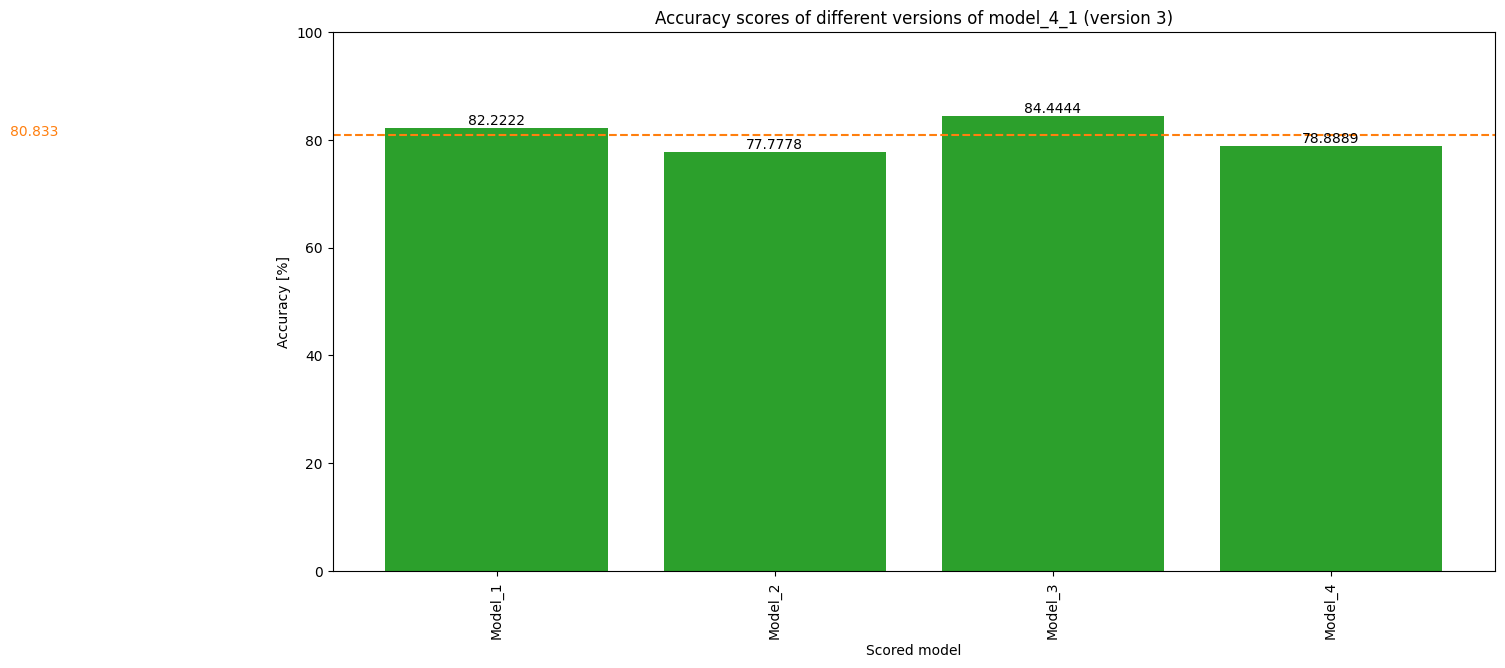

In [33]:
fig, ax = plt.subplots(figsize=(15, 7))

ax.bar(
    x= [key for key in model_4_3_dict.keys()],
    height= [value[1] for value in model_4_3_dict.values()],
    color= "tab:green"
)

ax.set_ylabel("Accuracy [%]")
ax.set_xlabel("Scored model")
ax.set_xticklabels([key for key in model_4_3_dict.keys()], rotation=90)
ax.set_title("Accuracy scores of different versions of model_4_1 (version 3)")
ax.set_ylim(0, 100)
plt.axhline(y=np.mean([value[1] for value in model_4_3_dict.values()]), color="tab:orange", linestyle="--")
ax.text(
    x= -1.75,
    y= np.mean([value[1] for value in model_4_3_dict.values()]),
    s= "%.3f" % np.mean([value[1] for value in model_4_3_dict.values()]),
    fontdict= {"color": "tab:orange"}
)
for container in ax.containers:
    ax.bar_label(container)

Let's get into `Model_3` a bit more! This looks like a good take to see if we can make more improvements without adding things like regularization 

In [34]:
model_4_3_params[3-1]

(19, 17, 15, 0.39, 0.31, 0.27)

In [35]:
model_4_4_params = []

for x in range(15):
    rate1 = np.random.randint(32, 51) / 100
    rate2 = np.random.randint(20, 41) / 100
    rate3 = np.random.randint(15, 31) / 100

    model_4_4_params.append((19, 17, 15, rate1, rate2, rate3))

model_4_4_dict = funcs.network_dict(
    input_shape= input_shape,
    params_list= model_4_4_params,
    callbacks= callbacks,
    data= datasets,
    iteration= 4
)

Scoring model 1/15
5/5 [==============================] - 1s 57ms/step
Scoring model 2/15
5/5 [==============================] - 0s 35ms/step
Scoring model 3/15
5/5 [==============================] - 1s 66ms/step
Scoring model 4/15
5/5 [==============================] - 0s 35ms/step
Scoring model 5/15
5/5 [==============================] - 0s 25ms/step
Scoring model 6/15
5/5 [==============================] - 1s 61ms/step
Scoring model 7/15
5/5 [==============================] - 1s 53ms/step
Scoring model 8/15
5/5 [==============================] - 1s 53ms/step
Scoring model 9/15
5/5 [==============================] - 1s 57ms/step
Scoring model 10/15
5/5 [==============================] - 1s 47ms/step
Scoring model 11/15
5/5 [==============================] - 1s 71ms/step
Scoring model 12/15
5/5 [==============================] - 1s 64ms/step
Scoring model 13/15
5/5 [==============================] - 1s 66ms/step
Scoring model 14/15
5/5 [==============================] - 1s 78ms/step
S

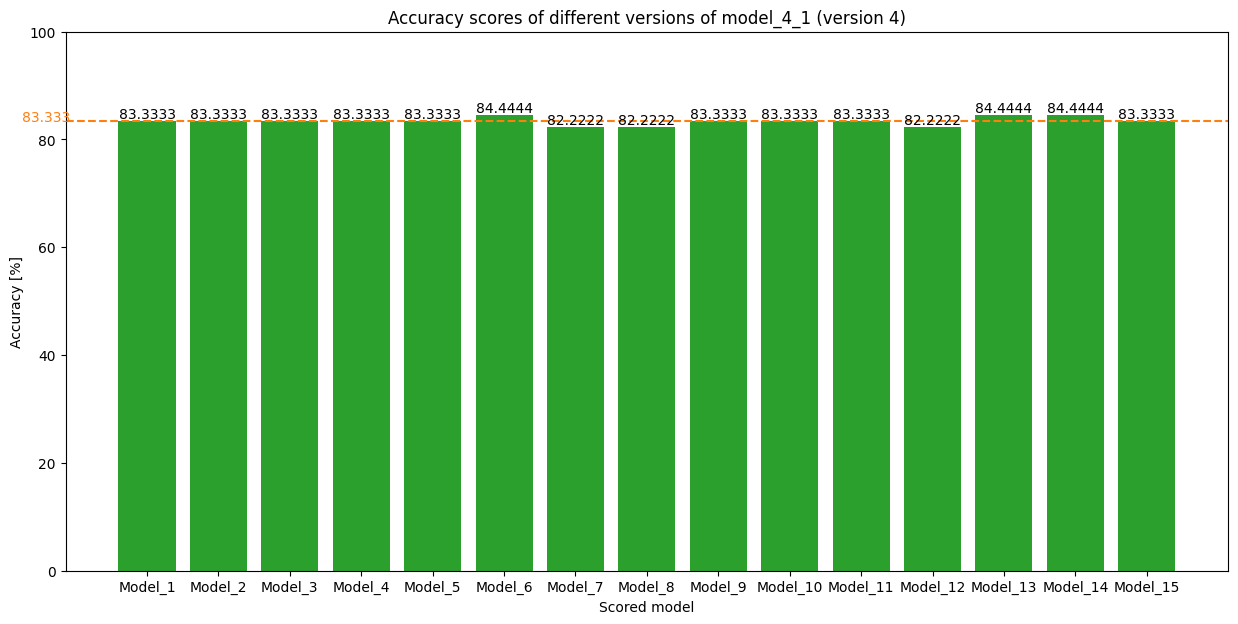

In [36]:
fig, ax = plt.subplots(figsize=(15, 7))

ax.bar(
    x= [key for key in model_4_4_dict.keys()],
    height= [value[1] for value in model_4_4_dict.values()],
    color= "tab:green"
)

ax.set_ylabel("Accuracy [%]")
ax.set_xlabel("Scored model")
# ax.set_xticklabels([key for key in model_4_4_dict.keys()], rotation=90)
ax.set_title("Accuracy scores of different versions of model_4_1 (version 4)")
ax.set_ylim(0, 100)
plt.axhline(y=np.mean([value[1] for value in model_4_4_dict.values()]), color="tab:orange", linestyle="--")
ax.text(
    x= -1.75,
    y= np.mean([value[1] for value in model_4_4_dict.values()]),
    s= "%.3f" % np.mean([value[1] for value in model_4_4_dict.values()]),
    fontdict= {"color": "tab:orange"}
)
for container in ax.containers:
    ax.bar_label(container)

The performance is fairly consistent between all those iterations - my final experimentation on this structure of the network will involve some final tweaks to the units, most likely units3, maybe some to units2. Let's see what were the rates for `Model_6`, `Model_13` and `Model_14`. 

In [37]:
print(model_4_4_params[6-1])
print(model_4_4_params[13-1])
print(model_4_4_params[14-1])

(19, 17, 15, 0.34, 0.4, 0.16)
(19, 17, 15, 0.38, 0.4, 0.23)
(19, 17, 15, 0.38, 0.37, 0.18)


In [38]:
model_4_5_params = []

for x in range(34, 39):
    for i in range(18, 24):
        rate1 = x/100
        rate3 = i/100
        param = (19, 17, 15, rate1, 0.4, rate3)

        if param not in model_4_4_params:
            model_4_5_params.append(param)
        else:
            pass

model_4_5_dict = funcs.network_dict(
    input_shape= input_shape,
    params_list= model_4_5_params,
    callbacks= callbacks,
    data= datasets,
    iteration= 4
)

Scoring model 1/29
5/5 [==============================] - 1s 83ms/step
Scoring model 2/29
5/5 [==============================] - 1s 31ms/step
Scoring model 3/29
5/5 [==============================] - 1s 78ms/step
Scoring model 4/29
5/5 [==============================] - 1s 94ms/step
Scoring model 5/29
5/5 [==============================] - 1s 98ms/step
Scoring model 6/29
5/5 [==============================] - 1s 59ms/step
Scoring model 7/29
5/5 [==============================] - 1s 85ms/step
Scoring model 8/29
5/5 [==============================] - 1s 66ms/step
Scoring model 9/29
5/5 [==============================] - 0s 30ms/step
Scoring model 10/29
5/5 [==============================] - 0s 43ms/step
Scoring model 11/29
5/5 [==============================] - 1s 61ms/step
Scoring model 12/29
5/5 [==============================] - 0s 44ms/step
Scoring model 13/29
5/5 [==============================] - 1s 64ms/step
Scoring model 14/29
5/5 [==============================] - 1s 61ms/step
S

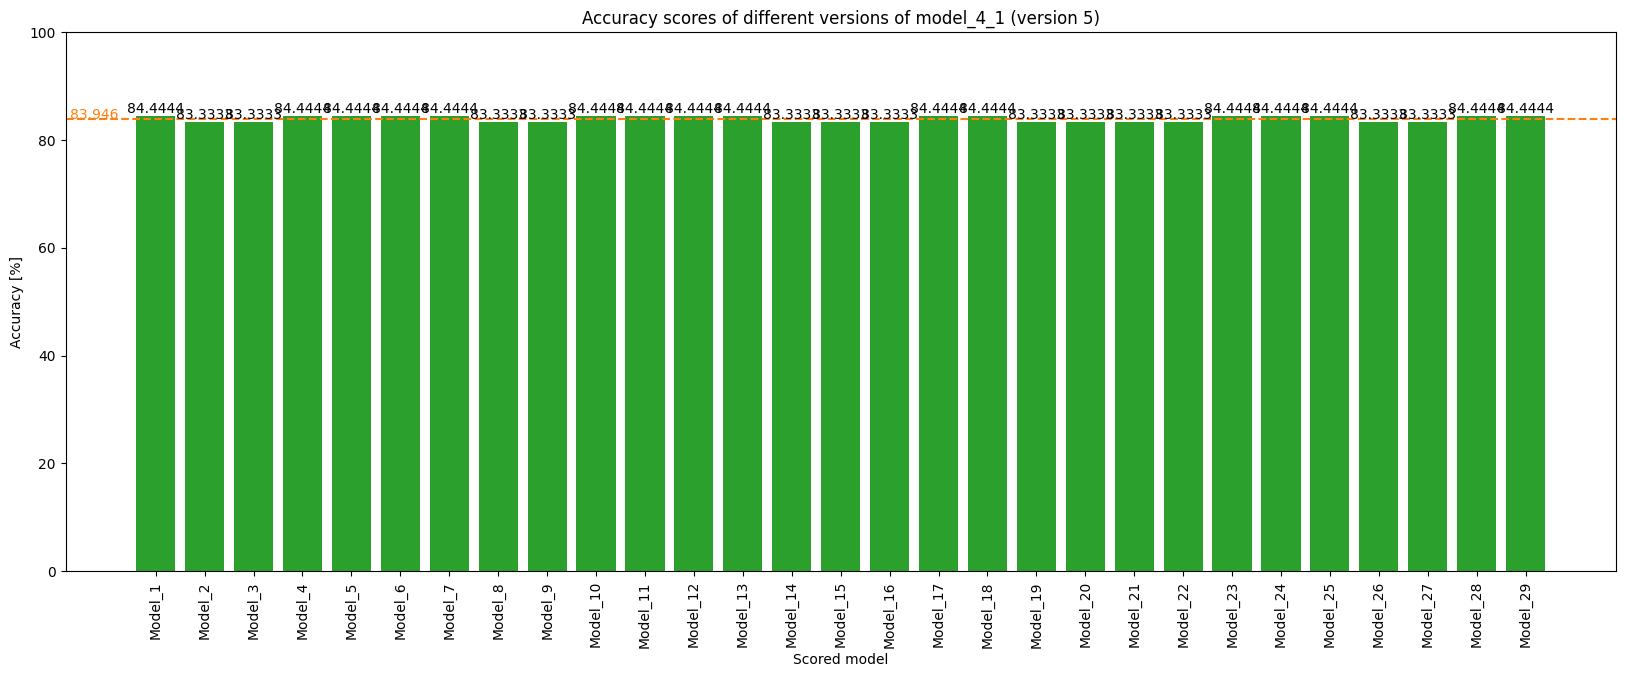

In [39]:
fig, ax = plt.subplots(figsize=(20, 7))

ax.bar(
    x= [key for key in model_4_5_dict.keys()],
    height= [value[1] for value in model_4_5_dict.values()],
    color= "tab:green"
)

ax.set_ylabel("Accuracy [%]")
ax.set_xlabel("Scored model")
ax.set_xticklabels([key for key in model_4_5_dict.keys()], rotation=90)
ax.set_title("Accuracy scores of different versions of model_4_1 (version 5)")
ax.set_ylim(0, 100)
plt.axhline(y=np.mean([value[1] for value in model_4_5_dict.values()]), color="tab:orange", linestyle="--")
ax.text(
    x= -1.75,
    y= np.mean([value[1] for value in model_4_5_dict.values()]),
    s= "%.3f" % np.mean([value[1] for value in model_4_5_dict.values()]),
    fontdict= {"color": "tab:orange"}
)
for container in ax.containers:
    ax.bar_label(container)

This was a fairly exhausting method to prove, that with tuning the dropout rates I can't seem to break the 84.444% threshold. And I said I'm not going to experiment with rates "that much". I will try about ten more models, but this time I will focus only on `units1` and `units2`, since changing the value of `units3` made an actual difference.

In [40]:
# These were the original parameters of the model that reached 84.444% accuracy (19, 17, 15, 0.39, 0.31, 0.27)

model_4_6_params = []

for x in range(20, 25)[::-1]:
    model_4_6_params.append((x, x-2, x-4, 0.39, 0.31, 0.27))
    model_4_6_params.append((x, x-1, x-3, 0.39, 0.31, 0.27))

model_4_6_params

[(24, 22, 20, 0.39, 0.31, 0.27),
 (24, 23, 21, 0.39, 0.31, 0.27),
 (23, 21, 19, 0.39, 0.31, 0.27),
 (23, 22, 20, 0.39, 0.31, 0.27),
 (22, 20, 18, 0.39, 0.31, 0.27),
 (22, 21, 19, 0.39, 0.31, 0.27),
 (21, 19, 17, 0.39, 0.31, 0.27),
 (21, 20, 18, 0.39, 0.31, 0.27),
 (20, 18, 16, 0.39, 0.31, 0.27),
 (20, 19, 17, 0.39, 0.31, 0.27)]

Now, let's feed the parameters to the `network_dict()` function and later plot the results. I feel I should've turned the plotting into functions, but I feel it's too late now.

In [41]:
model_4_6_dict = funcs.network_dict(
    input_shape= input_shape,
    params_list= model_4_6_params,
    callbacks= callbacks,
    data= datasets,
    iteration= 4
)

Scoring model 1/10
5/5 [==============================] - 1s 90ms/step
Scoring model 2/10
5/5 [==============================] - 1s 119ms/step
Scoring model 3/10
5/5 [==============================] - 1s 75ms/step
Scoring model 4/10
5/5 [==============================] - 1s 95ms/step
Scoring model 5/10
5/5 [==============================] - 1s 85ms/step
Scoring model 6/10
5/5 [==============================] - 1s 110ms/step
Scoring model 7/10
5/5 [==============================] - 1s 98ms/step
Scoring model 8/10
5/5 [==============================] - 1s 140ms/step
Scoring model 9/10
5/5 [==============================] - 1s 85ms/step
Scoring model 10/10
5/5 [==============================] - 1s 142ms/step
Done scoring!


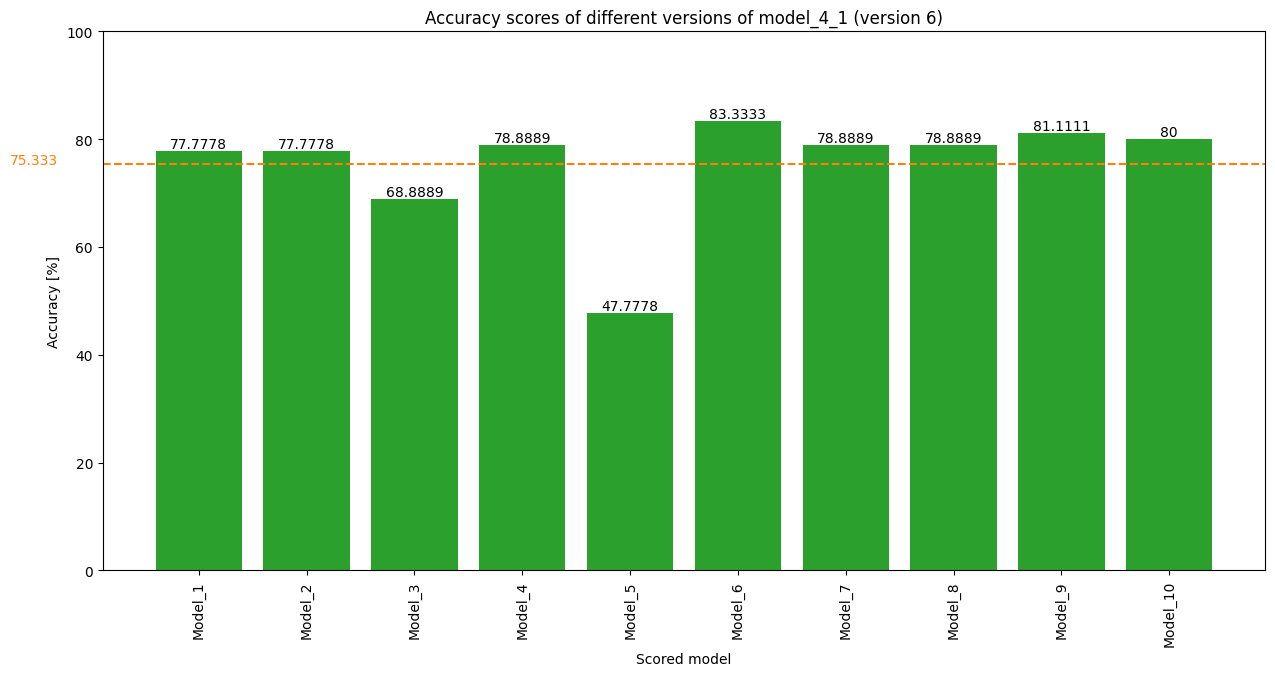

In [42]:
fig, ax = plt.subplots(figsize=(15, 7))

ax.bar(
    x= [key for key in model_4_6_dict.keys()],
    height= [value[1] for value in model_4_6_dict.values()],
    color= "tab:green"
)

ax.set_ylabel("Accuracy [%]")
ax.set_xlabel("Scored model")
ax.set_xticklabels([key for key in model_4_6_dict.keys()], rotation=90)
ax.set_title("Accuracy scores of different versions of model_4_1 (version 6)")
ax.set_ylim(0, 100)
plt.axhline(y=np.mean([value[1] for value in model_4_6_dict.values()]), color="tab:orange", linestyle="--")
ax.text(
    x= -1.75,
    y= np.mean([value[1] for value in model_4_6_dict.values()]),
    s= "%.3f" % np.mean([value[1] for value in model_4_6_dict.values()]),
    fontdict= {"color": "tab:orange"}
)
for container in ax.containers:
    ax.bar_label(container)

Now that's interesting. It didn't change anything for the better. Let's see which parameters were set for Model_6 and either try and work from there or just skip to the final network I'd like to create.

In [43]:
print(model_4_6_params[6-1])

(22, 21, 19, 0.39, 0.31, 0.27)


Let's experiment with the `units2` parameter.

In [44]:
model_4_7_params = []

for x in range(17, 22)[::-1]:
    model_4_7_params.append((22, x, x-2, 0.39, 0.31, 0.27))
    model_4_7_params.append((22, x, x-1, 0.39, 0.31, 0.27))

model_4_7_dict = funcs.network_dict(
    input_shape= input_shape,
    params_list= model_4_7_params,
    callbacks= callbacks,
    data= datasets,
    iteration= 4
)

Scoring model 1/10
5/5 [==============================] - 1s 180ms/step
Scoring model 2/10
5/5 [==============================] - 1s 125ms/step
Scoring model 3/10
5/5 [==============================] - 1s 86ms/step
Scoring model 4/10
5/5 [==============================] - 1s 101ms/step
Scoring model 5/10
5/5 [==============================] - 1s 176ms/step
Scoring model 6/10
5/5 [==============================] - 1s 118ms/step
Scoring model 7/10
5/5 [==============================] - 1s 153ms/step
Scoring model 8/10
5/5 [==============================] - 1s 150ms/step
Scoring model 9/10
5/5 [==============================] - 1s 121ms/step
Scoring model 10/10
5/5 [==============================] - 1s 114ms/step
Done scoring!


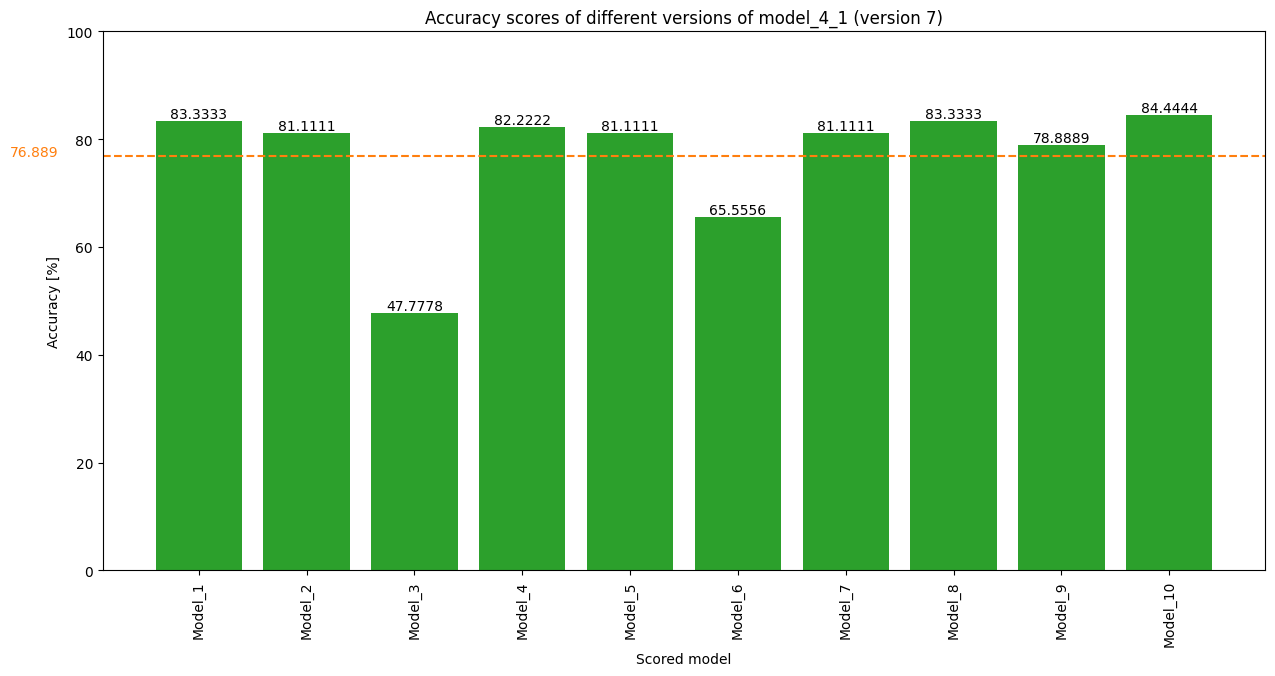

In [45]:
fig, ax = plt.subplots(figsize=(15, 7))

ax.bar(
    x= [key for key in model_4_7_dict.keys()],
    height= [value[1] for value in model_4_7_dict.values()],
    color= "tab:green"
)

ax.set_ylabel("Accuracy [%]")
ax.set_xlabel("Scored model")
ax.set_xticklabels([key for key in model_4_7_dict.keys()], rotation=90)
ax.set_title("Accuracy scores of different versions of model_4_1 (version 7)")
ax.set_ylim(0, 100)
plt.axhline(y=np.mean([value[1] for value in model_4_7_dict.values()]), color="tab:orange", linestyle="--")
ax.text(
    x= -1.75,
    y= np.mean([value[1] for value in model_4_7_dict.values()]),
    s= "%.3f" % np.mean([value[1] for value in model_4_7_dict.values()]),
    fontdict= {"color": "tab:orange"}
)
for container in ax.containers:
    ax.bar_label(container)

Right, let's see the parameters for both Model_9 and Model_10. I think I know what these are...

In [46]:
print(f"Model_9 parameters: {model_4_7_params[9-1]}")
print(f"Model_10 parameters: {model_4_7_params[10-1]}")

Model_9 parameters: (22, 17, 15, 0.39, 0.31, 0.27)
Model_10 parameters: (22, 17, 16, 0.39, 0.31, 0.27)


Clearly, the initial best setup of `units2` and `units3` does not work well with such a high value of `units1`. For any further training I think I will start with the 19, 17, 15 values for units 1 - 3. Let's now, as the final attempt, create a network that includes l1 and/or l2 regularization.

### l1 and l2 regularized network

This network will be rather quickly trained and experimented on. We will do a bit of random generating.

In [47]:
funcs.set_seed()
network_1 = tf.keras.Sequential([
    layers.BatchNormalization(input_shape= input_shape),
    layers.Dense(units= 19, activation= "relu"),
    layers.ActivityRegularization(l1= (np.random.randint(1, 33)/100), l2= 0),
    layers.Dropout(rate= 0.39),
    layers.BatchNormalization(),
    layers.Dense(units= 17, activation= "relu"),
    layers.ActivityRegularization(l1= (np.random.randint(0, 33)/100), l2= (np.random.randint(0, 33)/100)),
    layers.Dropout(rate= 0.31),
    layers.Dense(units= 15, activation= "relu"),
    layers.ActivityRegularization(l1= 0, l2= (np.random.randint(1, 33)/100)),
    layers.Dropout(rate= 0.27),
    layers.Dense(units=1, activation= "sigmoid")
])

network_1.compile(
    optimizer= "adam",
    loss= "binary_crossentropy",
    metrics= ["binary_accuracy"]
)

network_1.fit(
    x= X_train,
    y= y_train,
    validation_split= 0.25,
    batch_size= 20,
    epochs= 200,
    callbacks= callbacks,
    verbose= True
)

Epoch 1/200
8/8 [==============================] - 13s 1s/step - loss: 9.9192 - binary_accuracy: 0.4258 - val_loss: 931.3657 - val_binary_accuracy: 0.5000 - lr: 0.0010
Epoch 2/200
8/8 [==============================] - 4s 337ms/step - loss: 9.4071 - binary_accuracy: 0.5032 - val_loss: 393.9664 - val_binary_accuracy: 0.5000 - lr: 0.0010
Epoch 3/200
8/8 [==============================] - 2s 237ms/step - loss: 8.7172 - binary_accuracy: 0.5484 - val_loss: 215.3674 - val_binary_accuracy: 0.4808 - lr: 0.0010
Epoch 4/200
8/8 [==============================] - 2s 219ms/step - loss: 8.2219 - binary_accuracy: 0.6129 - val_loss: 133.9073 - val_binary_accuracy: 0.4808 - lr: 0.0010
Epoch 5/200
8/8 [==============================] - 2s 310ms/step - loss: 7.7181 - binary_accuracy: 0.5742 - val_loss: 89.3532 - val_binary_accuracy: 0.4808 - lr: 0.0010
Epoch 6/200
8/8 [==============================] - 2s 294ms/step - loss: 7.3480 - binary_accuracy: 0.5871 - val_loss: 62.8427 - val_binary_accuracy: 0.46

In [48]:
network_1_score = funcs.score_model(
    predictions= network_1.predict(
        x= X_test,
        batch_size= 20
    ),
    true_values= y_test
)

print("The network_1 scored %.3f" %(network_1_score * 100) + "%")

5/5 [==============================] - 0s 67ms/step
The network_1 scored 61.111%


Ha! That's bad! Let's see the summary of the network and maybe try to make some ammends.

In [49]:
network_1.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 batch_normalization (BatchN  (None, 13)               52        
 ormalization)                                                   
                                                                 
 dense (Dense)               (None, 19)                266       
                                                                 
 activity_regularization (Ac  (None, 19)               0         
 tivityRegularization)                                           
                                                                 
 dropout (Dropout)           (None, 19)                0         
                                                                 
 batch_normalization_1 (Batc  (None, 19)               76        
 hNormalization)                                                 
                                                      

In [50]:
funcs.set_seed()
network_2 = tf.keras.Sequential([
    layers.BatchNormalization(input_shape= input_shape),
    layers.Dense(units= 19, activation= "relu"),
    layers.ActivityRegularization(l1= (np.random.randint(1, 33)/100), l2= 0),
    layers.BatchNormalization(),
    layers.Dense(units= 17, activation= "relu"),
    layers.ActivityRegularization(l1= (np.random.randint(0, 33)/100), l2= (np.random.randint(0, 33)/100)),
    layers.Dense(units= 15, activation= "relu"),
    layers.ActivityRegularization(l1= 0, l2= (np.random.randint(1, 33)/100)),
    layers.Dense(units=1, activation= "sigmoid")
])

network_2.compile(
    optimizer= "adam",
    loss= "binary_crossentropy",
    metrics= ["binary_accuracy"]
)

network_2.fit(
    x= X_train,
    y= y_train,
    validation_split= 0.25,
    batch_size= 20,
    epochs= 200,
    callbacks= callbacks,
    verbose= False
)

network_2_score = funcs.score_model(
    predictions= network_2.predict(
        x= X_test,
        batch_size= 20
    ),
    true_values= y_test
)

print("Network_2 scored: %.3f" %(network_2_score * 100) + "%")

5/5 [==============================] - 1s 56ms/step
Network_2 scored: 60.000%


Okay, so the values of l1 and l2 regularizations I set made a small improvement when they were combined with `Dropout` layers. I will make a final experimentation attempt and I think I will move into final words for this notebook.

In [51]:
funcs.set_seed()
network_3 = tf.keras.Sequential([
    layers.BatchNormalization(input_shape= input_shape),
    layers.Dense(units= 19, activation= "relu"),
    layers.ActivityRegularization(l1= 0, l2= 0.3),
    layers.BatchNormalization(),
    layers.Dense(units= 17, activation= "relu"),
    layers.ActivityRegularization(l1= 0, l2= 0.2),
    layers.Dense(units= 15, activation= "relu"),
    layers.ActivityRegularization(l1= 0, l2= 0.1),
    layers.Dense(units=1, activation= "sigmoid")
])

network_3.compile(
    optimizer= "adam",
    loss= "binary_crossentropy",
    metrics= ["binary_accuracy"]
)

network_3.fit(
    x= X_train,
    y= y_train,
    validation_split= 0.25,
    batch_size= 20,
    epochs= 200,
    callbacks= callbacks,
    verbose= False
)

network_3_score = funcs.score_model(
    predictions= network_3.predict(
        x= X_test,
        batch_size= 20
    ),
    true_values= y_test
)

print("Network_3 scored: %.3f" %(network_3_score * 100) + "%")

5/5 [==============================] - 1s 124ms/step
Network_3 scored: 77.778%


Well that's promising - especially since I set up the values randomly. Fourth time's the charm - we will stick to l1 regularization and see how it does, when I give it the rates from the dropout layers.

In [52]:
funcs.set_seed()
network_4 = tf.keras.Sequential([
    layers.BatchNormalization(input_shape= input_shape),
    layers.Dense(units= 19, activation= "relu"),
    layers.ActivityRegularization(l1= 0.39, l2= 0),
    layers.BatchNormalization(),
    layers.Dense(units= 17, activation= "relu"),
    layers.ActivityRegularization(l1= 0.31, l2= 0),
    layers.Dense(units= 15, activation= "relu"),
    layers.ActivityRegularization(l1= 0.27, l2= 0),
    layers.Dense(units=1, activation= "sigmoid")
])

network_4.compile(
    optimizer= "adam",
    loss= "binary_crossentropy",
    metrics= ["binary_accuracy"]
)

network_4.fit(
    x= X_train,
    y= y_train,
    validation_split= 0.25,
    batch_size= 20,
    epochs= 200,
    callbacks= callbacks,
    verbose= False
)

network_4_score = funcs.score_model(
    predictions= network_4.predict(
        x= X_test,
        batch_size= 20
    ),
    true_values= y_test
)

print("Model_4 scored: %.3f" %(network_4_score * 100) + "%")

5/5 [==============================] - 1s 88ms/step
Model_4 scored: 54.444%


Well that's no good. Final attempt - using l2 regularizations with the dropout values and then we're off to rebuilding the OG network.

In [53]:
funcs.set_seed()
network_5 = tf.keras.Sequential([
    layers.BatchNormalization(input_shape= input_shape),
    layers.Dense(units= 19, activation= "relu"),
    layers.ActivityRegularization(l1= 0, l2= 0.39),
    layers.BatchNormalization(),
    layers.Dense(units= 17, activation= "relu"),
    layers.ActivityRegularization(l1= 0, l2= 0.31),
    layers.Dense(units= 15, activation= "relu"),
    layers.ActivityRegularization(l1= 0, l2= 0.27),
    layers.Dense(units=1, activation= "sigmoid")
])

network_5.compile(
    optimizer= "adam",
    loss= "binary_crossentropy",
    metrics= ["binary_accuracy"]
)

network_5.fit(
    x= X_train,
    y= y_train,
    validation_split= 0.25,
    batch_size= 20,
    epochs= 200,
    callbacks= callbacks,
    verbose= False
)

network_5_score = funcs.score_model(
    predictions= network_4.predict(
        x= X_test,
        batch_size= 20
    ),
    true_values= y_test
)

print("Model_5 scored: %.3f" %(network_5_score * 100) + "%")

5/5 [==============================] - 1s 16ms/step
Model_5 scored: 54.444%


And that's the same as the one above... If I was to spend more time on this notebook I believe I would experiemtn a bit more with the regularization rates. For now let's just recreate the best model we've had so far, export it and I think finally move on with this dataset.

In [54]:
funcs.set_seed()
final_model = tf.keras.Sequential([
    layers.BatchNormalization(input_shape= input_shape),
    layers.Dense(units= 19, activation= "relu"),
    layers.Dropout(rate= 0.39),
    layers.BatchNormalization(),
    layers.Dense(units= 17, activation= "relu"),
    layers.Dropout(rate= 0.31),
    layers.Dense(units= 15, activation= "relu"),
    layers.Dropout(rate= 0.27),
    layers.Dense(units= 1, activation= "sigmoid")
])

final_model.compile(
    optimizer= "adam",
    loss= "binary_crossentropy",
    metrics= ["binary_accuracy"]
)

final_model.fit(
    x= X_train,
    y= y_train,
    validation_split= 0.25,
    batch_size= 20,
    epochs= 200,
    callbacks= callbacks,
    verbose= False
)

final_model_score = funcs.score_model(
    predictions= final_model.predict(
        x= X_test,
        batch_size= 20
    ),
    true_values= y_test
)

print("Final network score: %.3f" %(final_model_score * 100) + "%")

5/5 [==============================] - 1s 165ms/step
Final network score: 84.444%


In [55]:
# funcs.save_network(
#     model= final_model,
#     name= "Network_Final"
# )

At this stage it feels like it's the right time to finish this notebook. 

For me the main takeaway is, that it's not really difficult to set up a neural network on your own. The difficult part begins when you need to tune it and add other layers than the typical `BatchNormalization`, `Dense` and `Dropout`. Still, I deeply enjoyed this experience and I don't regret spending so long on these two notebook and the `funcs.py` file. 

I'm open to any comments, feedback and constructive criticism - if you'd like to get in contact with me please see my <a href="https://aleksanderc.pythonanywhere.com">website</a> and either e-mail me or leave a message through the mailing form. 

Aleksander signing off, I'm off to work on other projects. 